In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tif
from pathlib import Path

# Set up paths
predictions_dir = Path("baseline/work_dir/unet_3class/predictions")
test_images_dir = Path("data/test/images")

# Create output directory for visualizations
output_dir = Path("visualization_outputs")
output_dir.mkdir(exist_ok=True)

print(f"Predictions directory: {predictions_dir}")
print(f"Test images directory: {test_images_dir}")

Predictions directory: baseline/work_dir/unet_3class/predictions
Test images directory: data/test/images


In [7]:
def load_image(image_path):
    """Load image from various formats"""
    if image_path.suffix.lower() in ['.tif', '.tiff']:
        return tif.imread(str(image_path))
    else:
        return np.array(Image.open(image_path))

def normalize_image(img):
    """Normalize image for display"""
    if img.dtype == np.uint8:
        return img.astype(np.float32) / 255.0
    elif img.max() > 1.0:
        return img.astype(np.float32) / img.max()
    else:
        return img.astype(np.float32)

def create_overlay(image, mask, alpha=0.6):
    """Create overlay of image and mask"""
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    
    # Normalize image
    image_norm = normalize_image(image)
    
    # Create colored mask
    colored_mask = np.zeros_like(image_norm)
    colored_mask[mask == 1] = [1, 0, 0]  # Red for interior
    colored_mask[mask == 2] = [0, 1, 0]  # Green for boundary
    
    # Create overlay
    overlay = image_norm * (1 - alpha) + colored_mask * alpha
    return np.clip(overlay, 0, 1)

def get_sample_files():
    """Get sample files for visualization"""
    overlay_files = list(predictions_dir.glob("overlay_*.tif")) + list(predictions_dir.glob("overlay_*.png"))
    
    sample_ids = []
    for overlay_file in overlay_files:
        filename = overlay_file.stem
        if filename.startswith("overlay_"):
            sample_id = filename[8:]
            sample_ids.append(sample_id)
    
    return sorted(sample_ids)

In [8]:
# Get first 10 samples
sample_ids = get_sample_files()
first_10_samples = sample_ids[:10]

print(f"Total available samples: {len(sample_ids)}")
print(f"First 10 samples: {first_10_samples}")

Total available samples: 74
First 10 samples: ['cell_00002', 'cell_00004', 'cell_00005', 'cell_00006', 'cell_00009', 'cell_00010', 'cell_00011', 'cell_00012', 'cell_00015', 'cell_00017']


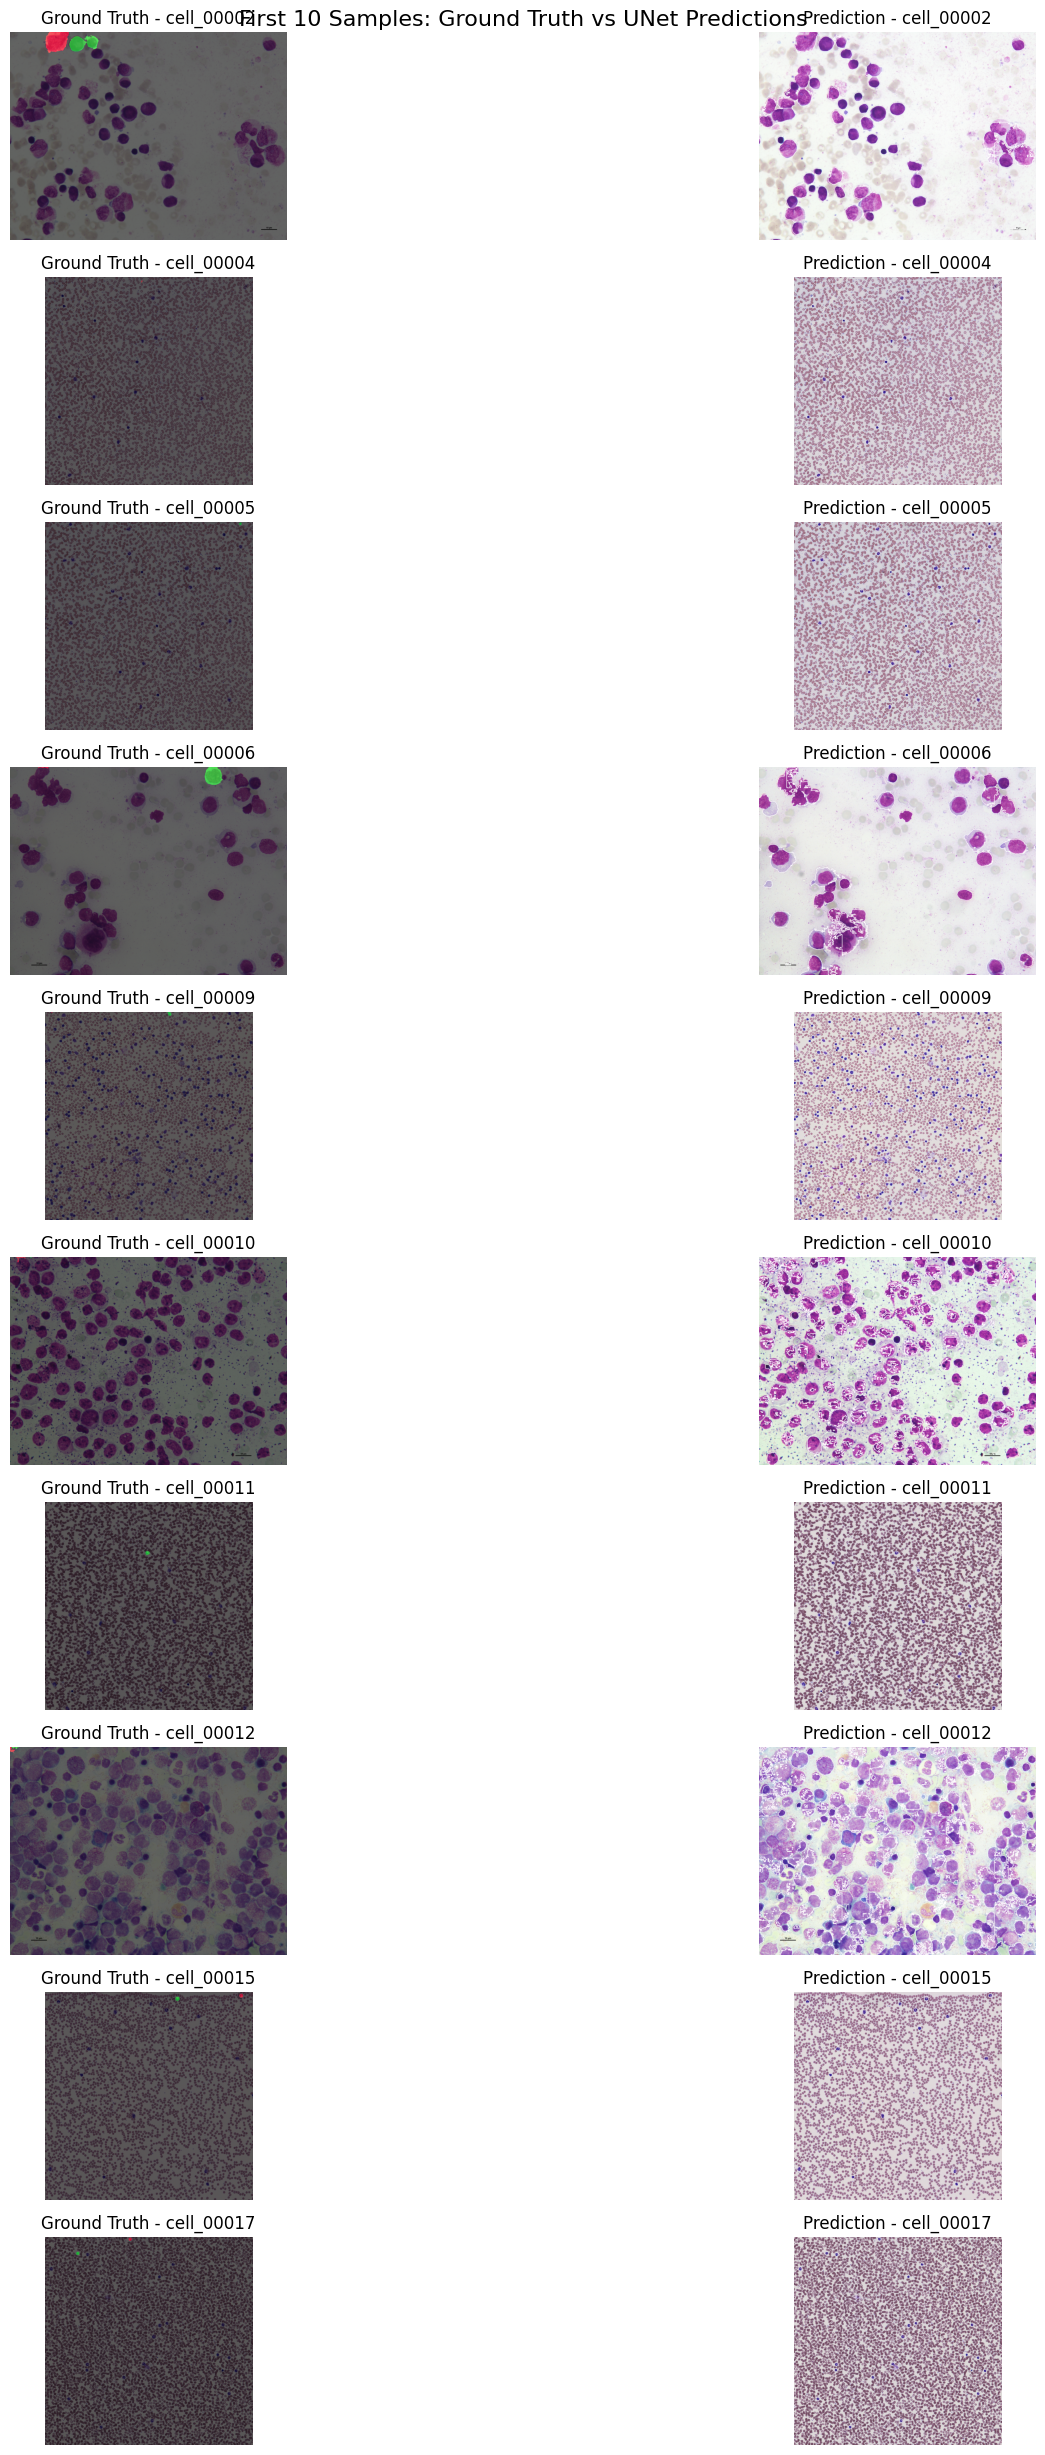

In [9]:
def visualize_first_10_samples(sample_ids, figsize=(20, 25)):
    """Visualize first 10 samples with predictions and ground truth"""
    
    fig, axes = plt.subplots(10, 2, figsize=figsize)
    
    for idx, sample_id in enumerate(sample_ids):
        # File paths
        overlay_file = predictions_dir / f"overlay_{sample_id}.tif"
        if not overlay_file.exists():
            overlay_file = predictions_dir / f"overlay_{sample_id}.png"
        
        gt_file = predictions_dir / f"{sample_id}_label.tiff"
        original_file = test_images_dir / f"{sample_id}.png"
        
        if overlay_file.exists() and gt_file.exists():
            # Load data
            prediction_overlay = load_image(overlay_file)
            gt_mask = load_image(gt_file)
            
            # Load original image if available
            original_image = None
            if original_file.exists():
                original_image = load_image(original_file)
            
            # Create ground truth overlay
            gt_overlay = create_overlay(original_image if original_image is not None else np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3)), gt_mask)
            
            # Plot ground truth
            axes[idx, 0].imshow(gt_overlay)
            axes[idx, 0].set_title(f"Ground Truth - {sample_id}")
            axes[idx, 0].axis('off')
            
            # Plot prediction
            if len(prediction_overlay.shape) == 3 and prediction_overlay.shape[2] == 3:
                axes[idx, 1].imshow(normalize_image(prediction_overlay))
            else:
                axes[idx, 1].imshow(prediction_overlay, cmap='gray')
            axes[idx, 1].set_title(f"Prediction - {sample_id}")
            axes[idx, 1].axis('off')
        else:
            axes[idx, 0].text(0.5, 0.5, f"Files not found\nfor {sample_id}", 
                            ha='center', va='center', transform=axes[idx, 0].transAxes)
            axes[idx, 0].set_title(f"Ground Truth - {sample_id}")
            axes[idx, 0].axis('off')
            
            axes[idx, 1].text(0.5, 0.5, f"Files not found\nfor {sample_id}", 
                            ha='center', va='center', transform=axes[idx, 1].transAxes)
            axes[idx, 1].set_title(f"Prediction - {sample_id}")
            axes[idx, 1].axis('off')
    
    plt.suptitle("First 10 Samples: Ground Truth vs UNet Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return fig

# Visualize first 10 samples
if first_10_samples:
    fig = visualize_first_10_samples(first_10_samples)
else:
    print("No samples found!")